# Benchmarks of VM proving times made by Aligned

## Table of Contents

- [About](#About)
- [GPU Benchmarks on RTX A6000](#GPU-Benchmarks-on-RTX-A6000)
  - [Fibonacci Benchmark](#Fibonacci-Benchmark)
  - [Keccak Benchmark](#Keccak-Benchmark)
  - [RSP Benchmark](#RSP-Benchmark)
- [CPU Benchmarks on AMD EPYC 8534P 64-Core Processor](#CPU-Benchmarks-on-AMD-EPYC-8534P-64-Core-Processor)
  - [Fibonacci Benchmark](#Fibonacci-Benchmark)
  - [Keccak Benchmark](#Keccak-Benchmark)
- [Appendix](#Appendix)
  - [RSP using different modes of SP1](#RSP-using-different-modes-of-SP1)



## About

These benchmarks aim to provide a neutral suite for measuring the efficiency of zkVMs. 

The benchmarks test the following programs:

- ✅ Fibonacci
- ✅ Keccak
- ️✅ [RSP (Reth Succinct Processor)](https://github.com/succinctlabs/rsp)

The benchmarks are run on the following zkVMs:

- [SP1](https://docs.succinct.xyz/docs/sp1/introduction)
- [Risc0](https://risczero.com/)
- [Pico](https://docs.brevis.network/)

You can run this Python notebook yourself to create new plots or analyze the data.

The Githbut repository is available [here](https://github.com/yetanotherco/zkvm_benchmarks).

Raw results can be found [here](https://github.com/yetanotherco/zkvm_benchmarks/tree/main/bench_results).

The full Jupyter notebook can be found [here](https://github.com/yetanotherco/zkvm_benchmarks/blob/main/benchmark.ipynb).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np  # Added for regression

In [2]:
# Constants
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
DARK_BG = '#1a1a1a'
GRID_ALPHA = 0.2
LEGEND_BG = '#2d2d2d'

## Some auxiliary functions

def time_to_seconds(time_str):
    time_str = time_str.strip()
    try:
        if 'm' in time_str:
            parts = time_str.split('m')
            minutes = float(parts[0])
            seconds = 0
            if len(parts) > 1 and parts[1]:
                seconds = float(parts[1].replace('s', ''))
            return minutes * 60 + seconds
        else:
            return float(time_str.replace('s', ''))
    except Exception as e:
        print(f"Error parsing time: {time_str}")
        print(f"Error details: {e}")
        return None
    

def load_data(input_csv_path):
    # Read data from CSV
    # Return DataFrame with columns for Seconds and Minutes
    df = pd.read_csv(input_csv_path)
    df['N'] = df['N'].astype(int)
    
    df['Seconds'] = df['Time'].apply(time_to_seconds)
    df['Minutes'] = df['Seconds'] / 60
    return df

def print_dataframe(df):
    print("\nData sorted by Prover and N for validation:")
    pd.set_option('display.float_format', '{:.2f}'.format)
    validation_df = df.sort_values(['Prover', 'N'])[['Prover', 'N', 'Time', 'Minutes']]
    print(validation_df.to_string())
    
def format_axis_numbers(value, _):
    """Format numbers in millions (M) or thousands (K) for axis labels."""
    if value >= 1_000_000:
        millions = value / 1_000_000
        return f'{int(millions)}M' if millions.is_integer() else f'{millions:.1f}M'
    elif value >= 1_000:
        return f'{int(value/1_000)}K'
    return str(int(value))

def plot_points(ax, x_data, y_data, color, label, style='o-', **kwargs):
    """Generic function to plot points with specified scaling."""
    plot_func = ax.plot if kwargs.get('linear_scale', False) else ax.loglog
    plot_func(
        x_data,
        y_data,
        style,
        label=label,
        linewidth=kwargs.get('linewidth', 2),
        markersize=kwargs.get('markersize', 8),
        color=color,
        alpha=kwargs.get('alpha', 1.0)
    )

def get_regression_function(x_data, y_data, use_linear):
    """Calculate regression function based on scale type."""
    if use_linear:
        coeffs = np.polyfit(x_data, y_data, 1)
        return np.poly1d(coeffs), f'y={coeffs[0]:.2e}x + {coeffs[1]:.2f}'
    else:
        log_x = np.log10(x_data)
        log_y = np.log10(y_data)
        coeffs = np.polyfit(log_x, log_y, 1)
        func = lambda x: 10 ** coeffs[1] * x ** coeffs[0]
        return func, f'y={10 ** coeffs[1]:.2e}x^{coeffs[0]:.2f}'

def plot_data(df, x_col, y_col, group_col, x_label, y_label, function_type,
              use_linear=False, use_regression=False,
              colors=COLORS, dark_bg='#1a1a1a', grid_alpha=0.3, legend_bg='#252526'):
    """
    Create a performance comparison plot with consistent axis scaling.
    
    Parameters:
    - df: DataFrame with data
    - x_col, y_col: Column names for x and y data
    - group_col: Column name for grouping data
    - x_label, y_label: Axis labels
    - function_type: Title prefix
    - use_linear: Boolean flag for linear scaling (both axes)
    - use_regression: Boolean flag for regression lines
    - colors: List of colors for plotting
    - dark_bg, grid_alpha, legend_bg: Styling parameters
    """
    # Set up plot style and figure
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(10, 6), facecolor=dark_bg)
    ax = plt.gca()
    ax.set_facecolor(dark_bg)

    # Plot data for each group
    for i, group in enumerate(df[group_col].unique()):
        group_data = df[df[group_col] == group].sort_values(x_col)
        color = colors[i % len(colors)]
        
        plot_points(
            ax,
            group_data[x_col],
            group_data[y_col],
            color,
            label=group,
            style='o' if use_regression else 'o-',
            linear_scale=use_linear,
            markersize=8
        )
        
        # Add regression lines if requested
        if use_regression:
            reg_func, reg_label = get_regression_function(
                group_data[x_col],
                group_data[y_col],
                use_linear
            )
            
            # Generate x range based on scale
            if use_linear:
                x_range = np.array([min(group_data[x_col]), max(group_data[x_col])])
            else:
                x_range = np.logspace(
                    np.log10(min(group_data[x_col])),
                    np.log10(max(group_data[x_col])),
                    100
                )
                
            plot_points(
                ax,
                x_range,
                reg_func(x_range),
                color,
                label=f'{group} regression ({reg_label})',
                style='-',
                linear_scale=use_linear,
                alpha=0.7
            )

    # Configure axes and labels
    ax.set_xlabel(x_label, color='white')
    ax.set_ylabel(y_label, color='white')
    scale_type = 'Linear' if use_linear else 'LogLog'
    ax.set_title(f'{function_type} Performance Comparison ({scale_type} Scale)',
                 color='white')

    # Configure grid and legend
    ax.grid(True, alpha=grid_alpha, color='gray')
    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        frameon=True,
        facecolor=legend_bg,
        edgecolor='white',
        labelcolor='white'
    )

    # Set tick colors and number formatting
    ax.tick_params(axis='both', colors='white')
    formatter = ticker.FuncFormatter(
        lambda x, _: f'{x:,.0f}' if use_linear else f'{x:.0e}')
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.show()
  
def show_sample_at_n(df, n, column='N', factor=1_000_000):    
    # Filter for n
    n_rows = df[df['N'] == n]
    n_display = n_rows[['Prover', 'N', 'Time']].copy()
    n_display['N'] = (n_display['N'] / factor)  # Truncates, but no decimals here anyway
    display(n_display.rename(columns={'N': column}))  

def show_max_sample_time(df, column='N', factor=1_000_000):    
    # Dynamically find the maximum N value
    max_n = df['N'].max()
    show_sample_at_n(df, max_n, column, factor)
    
def show_max_sample_size(df, column='Size (MB)', factor=1_000_000):
    max_n = df['N'].max()
    n_rows = df[df['N'] == max_n]
    n_display = n_rows[['Prover', 'N', 'Size']].copy()
    n_display['Size'] = (n_display['Size'] / factor) # Truncates, but no decimals here anyway
    display(n_display.rename(columns={'Size': column, 'N': 'Megagas'}))  
    
    
def calculate_kps(df):
    # Calculate Keccaks per second for highest N value of each prover
    kps_data = []
    for prover in df['Prover'].unique():
        prover_data = df[df['Prover'] == prover]
        max_n_row = prover_data.loc[prover_data['N'].idxmax()]
        
        # Each N represents one Keccak hash
        keccaks_per_second = max_n_row['N'] / max_n_row['Seconds'] / 1024
        
        kps_data.append({
            'Prover': prover,
            'KiB/sec': keccaks_per_second
        })
    
    # Create DataFrame and sort by performance
    kps_df = pd.DataFrame(kps_data)
    kps_df = kps_df.sort_values('KiB/sec', ascending=False)
    
    # Display results as a table
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    # Optionally, you can use the following line to display it as a table in Jupyter Notebook
    display(kps_df)
    

## GPU Benchmarks on RTX A6000

The data was collected on a server with the following specs:

- GPU: NVIDIA RTX A6000 (48GB)
- RAM: 44GB
- OS: Ubuntu 22 LTS

### Fibonacci Benchmark
In this section, we evaluate the performance of Fibonacci across various provers.

The data is sourced from `bench_results/fibo_6_mar_25_A6000.csv`.

In [3]:
input_csv_path = 'bench_results/fibo_6_mar_25_A6000.csv'
df = load_data(input_csv_path)

For validation, we will display the data sorted by Prover and N.

In [4]:
print_dataframe(df)


Data sorted by Prover and N for validation:
              Prover         N     Time  Minutes
2              Risc0     10000     1.7s     0.03
5              Risc0    100000     5.6s     0.09
8              Risc0   1000000    48.9s     0.81
11             Risc0  10000000  7m45.5s     7.76
0           SP1-AVX2     10000    13.9s     0.23
3           SP1-AVX2    100000    13.3s     0.22
6           SP1-AVX2   1000000    22.8s     0.38
9           SP1-AVX2  10000000  1m46.8s     1.78
1   SP1-AVX2-Groth16     10000    53.1s     0.89
4   SP1-AVX2-Groth16    100000    53.7s     0.90
7   SP1-AVX2-Groth16   1000000   1m9.2s     1.15
10  SP1-AVX2-Groth16  10000000  2m27.1s     2.45


#### Plot: Log N vs Log Time

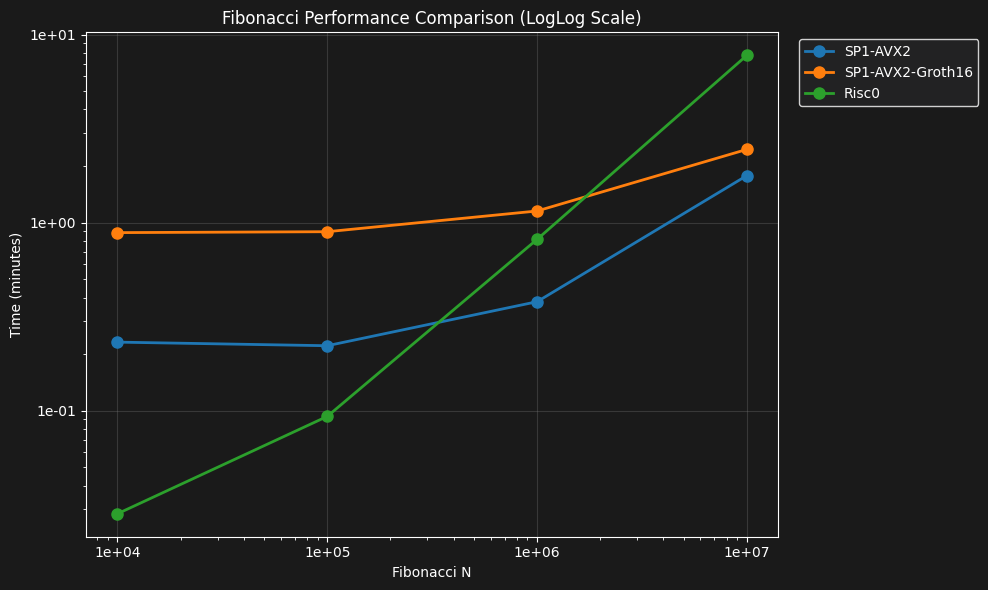

In [5]:
plot_data(df, 'N', 'Minutes', 'Prover', 'Fibonacci N', 'Time (minutes)', 'Fibonacci')

#### Time used at biggest sample taken

In [6]:
show_max_sample_time(df, column='N (Millions)' ,factor=1_000_000)

,Prover,N (Millions),Time
9,SP1-AVX2,10.00,1m46.8s
10,SP1-AVX2-Groth16,10.00,2m27.1s
11,Risc0,10.00,7m45.5s


### Keccak Benchmark

In this section we evaluate the performance of Keccak across various provers.

The data is sourced from `bench_results/keccak_14_mar_25_A6000.csv`.

In [7]:
input_csv_path = 'bench_results/keccak_14_mar_25_A6000.csv'
df = load_data(input_csv_path)

For validation, we will display the data sorted by Prover and N.

In [8]:
print_dataframe(df)


Data sorted by Prover and N for validation:
              Prover          N      Time  Minutes
14             Risc0        100      5.1s     0.08
15             Risc0       1000      5.2s     0.09
16             Risc0      10000      5.7s     0.10
17             Risc0     100000     17.6s     0.29
18             Risc0    1000000   1m58.3s     1.97
19             Risc0   10000000  19m10.1s    19.17
0           SP1-AVX2        100     15.3s     0.26
2           SP1-AVX2       1000     15.3s     0.26
4           SP1-AVX2      10000     15.3s     0.26
6           SP1-AVX2     100000     15.9s     0.27
8           SP1-AVX2    1000000     26.3s     0.44
10          SP1-AVX2   10000000   2m11.5s     2.19
12          SP1-AVX2  100000000  19m48.4s    19.81
1   SP1-AVX2-Groth16        100     53.9s     0.90
3   SP1-AVX2-Groth16       1000     53.6s     0.89
5   SP1-AVX2-Groth16      10000     54.3s     0.90
7   SP1-AVX2-Groth16     100000     54.0s     0.90
9   SP1-AVX2-Groth16    1000000    1m

#### Plot: Log N vs Log Time

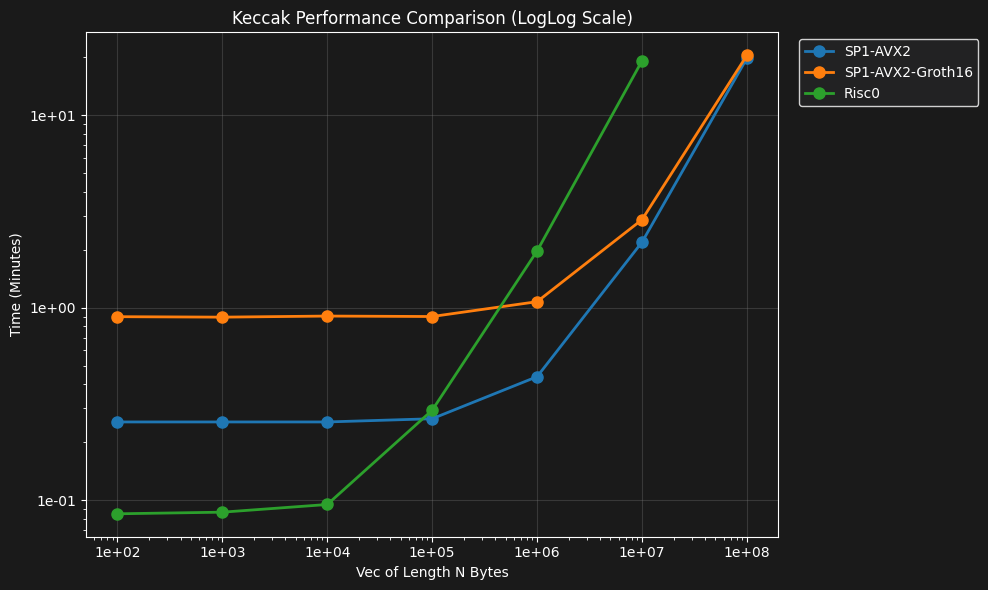

In [9]:
plot_data(df, 'N', 'Minutes', 'Prover', 'Vec of Length N Bytes', 'Time (Minutes)', 'Keccak')

#### KiB hased per second at max sample

In [10]:
calculate_kps(df)

,Prover,KiB/sec
0,SP1-AVX2,82.17
1,SP1-AVX2-Groth16,79.44
2,Risc0,8.49


#### Time used at 10M and 100M bytes

In [11]:
n1 = 10_000_000
n2 = 100_000_000

show_sample_at_n(df, n1, column='Bytes (Millions)')
show_sample_at_n(df, n2, column='Bytes (Millions)')

,Prover,Bytes (Millions),Time
10,SP1-AVX2,10.00,2m11.5s
11,SP1-AVX2-Groth16,10.00,2m52.1s
19,Risc0,10.00,19m10.1s


,Prover,Bytes (Millions),Time
12,SP1-AVX2,100.00,19m48.4s
13,SP1-AVX2-Groth16,100.00,20m29.3s


### RSP Benchmark

In this section we evaluate the performance of [RSP](https://github.com/succinctlabs/rsp) across various provers over blocks with different amounts of Gas.

Notice the cost is not purely lineal, since there can be blocks that require more keccaks and are more expensive to prove than others. For example, the block of 27M gas is cheaper to prove than the one of 18M Gas


The data is sourced from `bench_results/rsp_18_mar_25_A6000.csv`.

In [12]:
input_csv_path = 'bench_results/rsp_18_mar_25_A6000.csv'
df = load_data(input_csv_path)

For validation, we will display the data sorted by Prover and N.

In [13]:
print_dataframe(df)


Data sorted by Prover and N for validation:
       Prover   N       Time  Minutes
1   RSP RISC0   1     6m6.5s     6.11
3   RSP RISC0   3    16m5.2s    16.09
5   RSP RISC0   9   44m28.9s    44.48
7   RSP RISC0  18   77m48.4s    77.81
9   RSP RISC0  27    37m9.0s    37.15
11  RSP RISC0  36  176m32.8s   176.55
0     RSP SP1   1      53.5s     0.89
2     RSP SP1   3    1m50.7s     1.84
4     RSP SP1   9    4m16.2s     4.27
6     RSP SP1  18    7m17.8s     7.30
8     RSP SP1  27    3m32.3s     3.54
10    RSP SP1  36   14m30.1s    14.50


#### Plot: Block Megagas vs Time

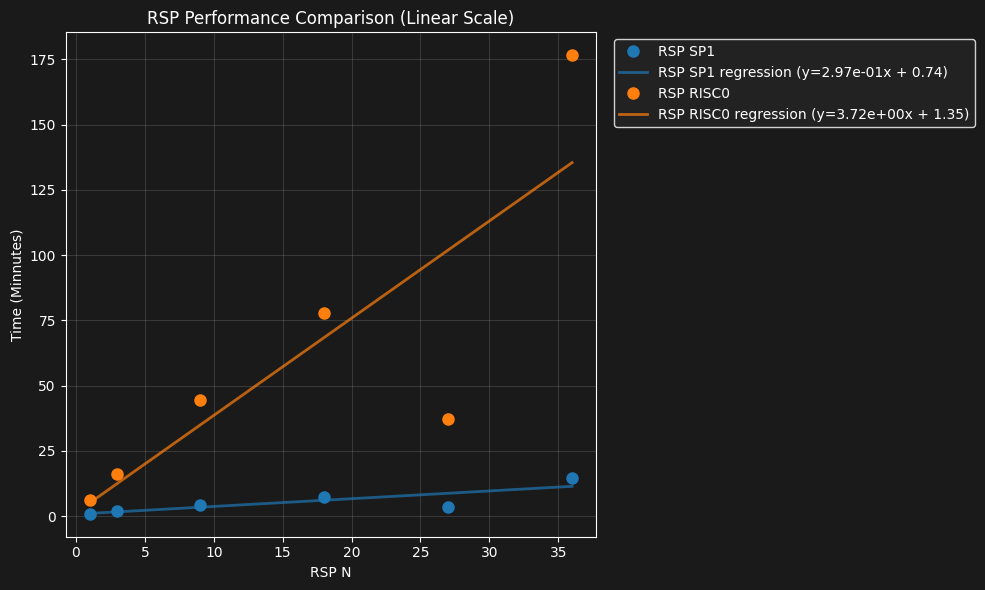

In [14]:
plot_data(df, 'N', 'Minutes', 'Prover', 'RSP N', 'Time (Minnutes)', 'RSP', use_linear=True, use_regression=True)

Note: The 27Mgas block has fewer transactions than the other blocks, but one of them is a high cpu usage transaction.

#### Time used for a 36M gas block

In [15]:
show_max_sample_time(df, column='Megagas', factor=1)

,Prover,Megagas,Time
10,RSP SP1,36.00,14m30.1s
11,RSP RISC0,36.00,176m32.8s


## CPU Benchmarks on AMD EPYC 8534P 64-Core Processor

The data was collected on a server with the following specs:

- CPU: AMD EPYC 8534P 64-Core Processor
- RAM: 576GB
- OS: Ubuntu 24 LTS

### Fibonacci Benchmark

In this section we evaluate the performance of Fibonacci across various provers.

The data is sourced from `bench_results/fibo_5_mar_25_epyc8534p_64c_576gb.csv`.

In [16]:
input_csv_path = 'bench_results/fibo_5_mar_25_epyc8534p_64c_576gb.csv'
df = load_data(input_csv_path)

For validation, we will display the data sorted by Prover and N.

In [17]:
print_dataframe(df)


Data sorted by Prover and N for validation:
                Prover        N     Time  Minutes
0          Pico-AVX512    10000    22.9s     0.38
4          Pico-AVX512   100000    35.5s     0.59
8          Pico-AVX512  1000000  1m46.0s     1.77
12         Pico-AVX512  4000000  5m18.6s     5.31
3                Risc0    10000    10.8s     0.18
7                Risc0   100000    50.9s     0.85
11               Risc0  1000000  7m53.1s     7.89
15               Risc0  4000000  31m2.0s    31.03
1           SP1-AVX512    10000    16.0s     0.27
5           SP1-AVX512   100000    34.0s     0.57
9           SP1-AVX512  1000000  1m42.8s     1.71
13          SP1-AVX512  4000000  5m21.2s     5.35
2   SP1-AVX512-Groth16    10000  1m18.5s     1.31
6   SP1-AVX512-Groth16   100000  1m36.4s     1.61
10  SP1-AVX512-Groth16  1000000  2m45.8s     2.76
14  SP1-AVX512-Groth16  4000000  6m29.4s     6.49


#### Plot: Log N vs Log Time

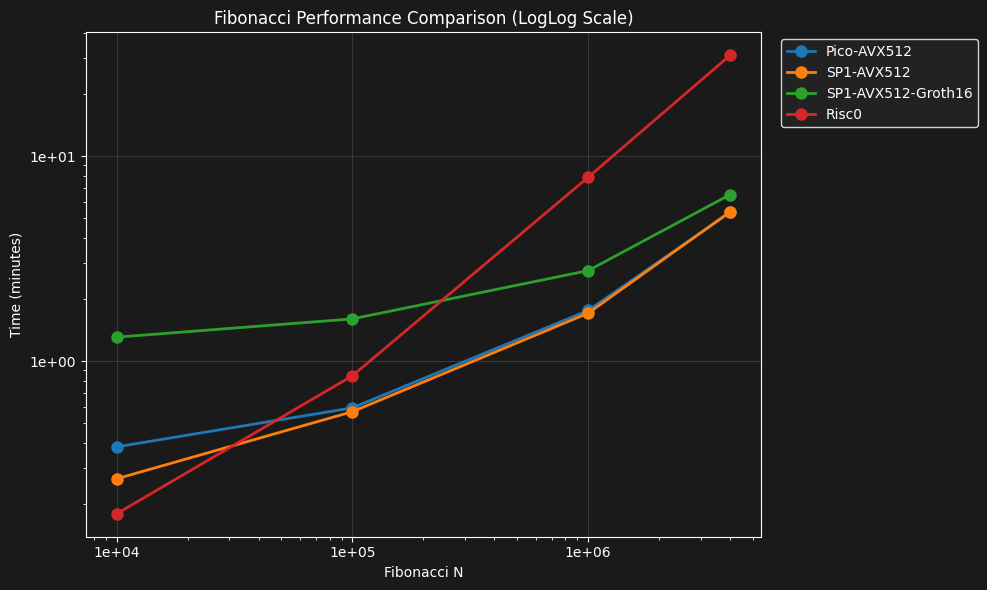

In [18]:
plot_data(df, 'N', 'Minutes', 'Prover', 'Fibonacci N', 'Time (minutes)', 'Fibonacci')

#### Time used at biggest sample taken

In [19]:
show_max_sample_time(df)

,Prover,N,Time
12,Pico-AVX512,4.00,5m18.6s
13,SP1-AVX512,4.00,5m21.2s
14,SP1-AVX512-Groth16,4.00,6m29.4s
15,Risc0,4.00,31m2.0s


### Keccak Benchmark

In this section we evaluate the performance of Keccak across various provers.

The data is sourced from `bench_results/keccak_18_mar_25_epyc8534p_64c_576gb.csv`.

In [20]:
input_csv_path = 'bench_results/keccak_18_mar_25_epyc8534p_64c_576gb.csv'
df = load_data(input_csv_path)

For validation, we will display the data sorted by Prover and N.

In [21]:
print_dataframe(df)


Data sorted by Prover and N for validation:
                 Prover         N       Time  Minutes
0   Pico-AVX512 Groth16       100      29.0s     0.48
3   Pico-AVX512 Groth16      1000      29.1s     0.49
6   Pico-AVX512 Groth16     10000      29.9s     0.50
9   Pico-AVX512 Groth16    100000      39.7s     0.66
12  Pico-AVX512 Groth16   1000000    1m45.3s     1.75
15  Pico-AVX512 Groth16  10000000   12m20.4s    12.34
18                Risc0       100      33.4s     0.56
19                Risc0      1000      34.3s     0.57
20                Risc0     10000      44.2s     0.74
21                Risc0    100000    2m20.1s     2.33
22                Risc0   1000000   16m47.0s    16.78
23                Risc0  10000000  158m15.4s   158.26
1            SP1-AVX512       100      53.8s     0.90
4            SP1-AVX512      1000      54.1s     0.90
7            SP1-AVX512     10000      54.6s     0.91
10           SP1-AVX512    100000     1m3.3s     1.05
13           SP1-AVX512   1000000    

#### Plot: Log N vs Log Time

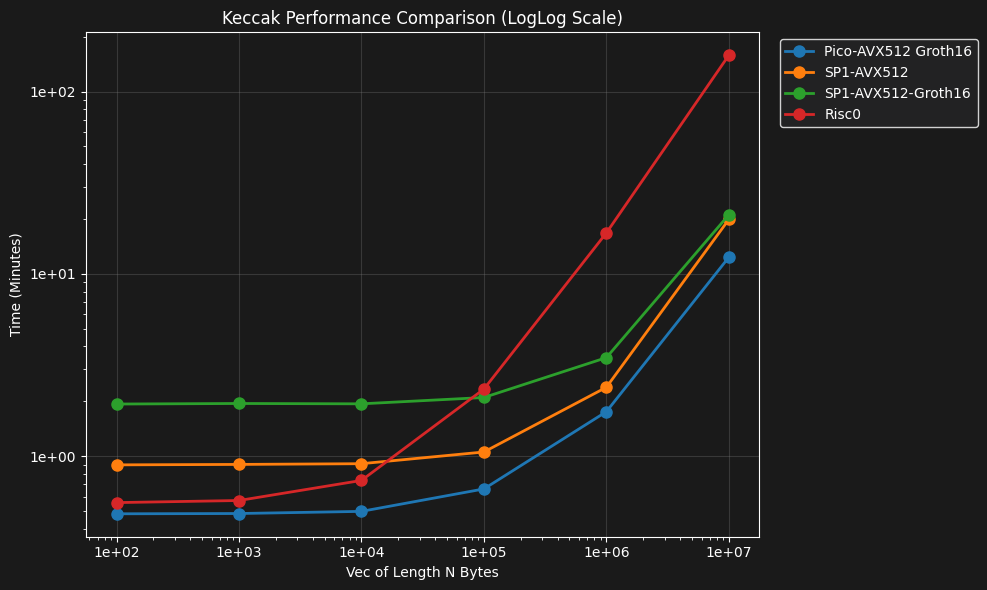

In [22]:
plot_data(df, 'N', 'Minutes', 'Prover', 'Vec of Length N Bytes', 'Time (Minutes)', 'Keccak')

#### KiB hased per second at max sample

In [23]:
calculate_kps(df)

,Prover,KiB/sec
0,Pico-AVX512 Groth16,13.19
1,SP1-AVX512,8.18
2,SP1-AVX512-Groth16,7.71
3,Risc0,1.03


#### Time used at 100K bytes and 10M bytes

In [24]:
n1 = 100_000
n2 = 10_000_000

show_sample_at_n(df, n1, column='Bytes (Millions)')
show_sample_at_n(df, n2, column='Bytes (Millions)')

,Prover,Bytes (Millions),Time
9,Pico-AVX512 Groth16,0.10,39.7s
10,SP1-AVX512,0.10,1m3.3s
11,SP1-AVX512-Groth16,0.10,2m6.0s
21,Risc0,0.10,2m20.1s


,Prover,Bytes (Millions),Time
15,Pico-AVX512 Groth16,10.00,12m20.4s
16,SP1-AVX512,10.00,19m53.3s
17,SP1-AVX512-Groth16,10.00,21m6.0s
23,Risc0,10.00,158m15.4s


# Appendix

### RSP using different modes of SP1
The following plot shows the difference between the Core, Compressed and Groth16 mode of SP1

The data is sourced from `bench_results/rsp_sp1_modes_13_mar_25_A6000.csv`

In [25]:
input_csv_path = 'bench_results/rsp_sp1_modes_13_mar_25_A6000.csv'
df = load_data(input_csv_path)

For validation, we will display the data sorted by Prover and N.


In [26]:
print_dataframe(df)


Data sorted by Prover and N for validation:
                Prover   N      Time  Minutes
0   RSP SP1-Compressed   1     54.5s     0.91
3   RSP SP1-Compressed   3   1m52.0s     1.87
6   RSP SP1-Compressed   9   4m18.3s     4.31
9   RSP SP1-Compressed  18   7m16.8s     7.28
12  RSP SP1-Compressed  27   3m32.8s     3.55
15  RSP SP1-Compressed  36  14m31.9s    14.53
2         RSP SP1-Core   1     52.9s     0.88
5         RSP SP1-Core   3   1m48.1s     1.80
8         RSP SP1-Core   9   4m12.8s     4.21
11        RSP SP1-Core  18   7m12.0s     7.20
14        RSP SP1-Core  27   3m26.9s     3.45
17        RSP SP1-Core  36  14m42.2s    14.70
1      RSP SP1-Groth16   1   1m32.7s     1.55
4      RSP SP1-Groth16   3   2m30.0s     2.50
7      RSP SP1-Groth16   9   4m56.4s     4.94
10     RSP SP1-Groth16  18   7m56.9s     7.95
13     RSP SP1-Groth16  27   4m11.8s     4.20
16     RSP SP1-Groth16  36  15m16.2s    15.27


#### Plot: Block Megagas vs Time for SP1 different modes

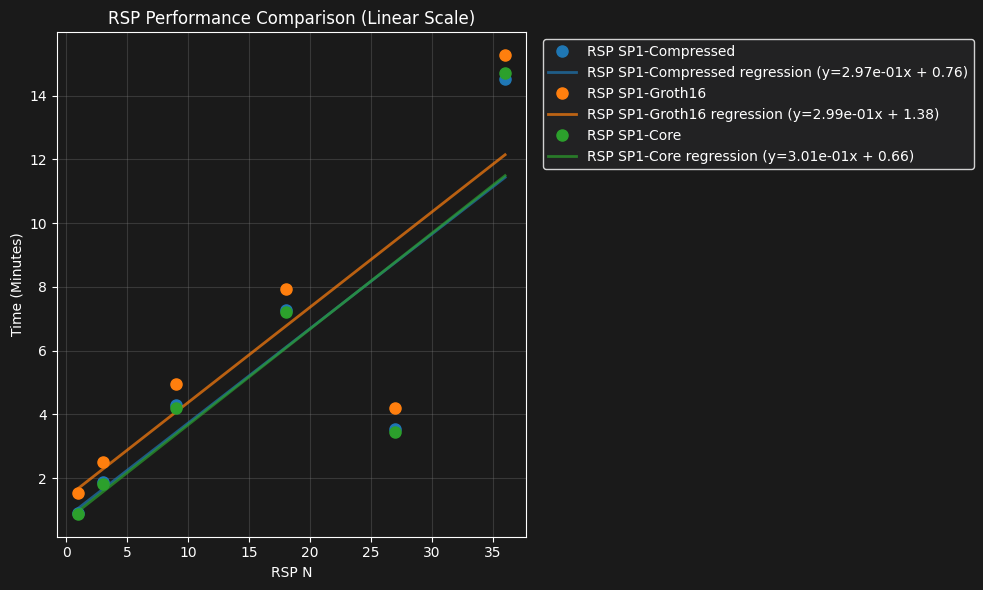

In [27]:
plot_data(df, 'N', 'Minutes', 'Prover', 'RSP N', 'Time (Minutes)', 'RSP', use_linear=True, use_regression=True)

#### Time used for a 36M gas block

In [28]:
show_max_sample_time(df, column='Megagas', factor=1)

,Prover,Megagas,Time
15,RSP SP1-Compressed,36.00,14m31.9s
16,RSP SP1-Groth16,36.00,15m16.2s
17,RSP SP1-Core,36.00,14m42.2s


#### Plot: Block Megagas vs Proof Size 

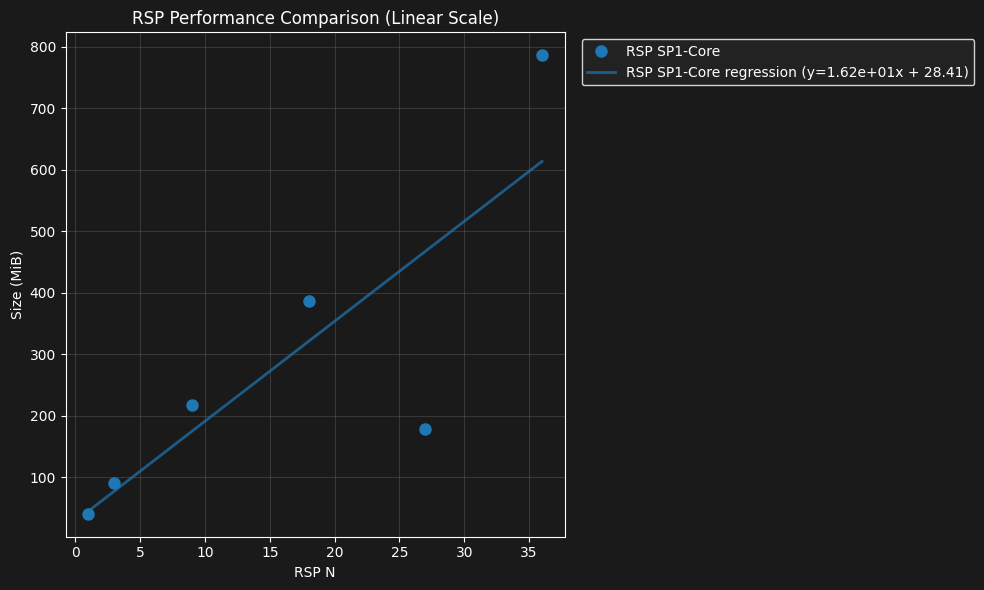

In [29]:
df_core = df[df['Prover'] == 'RSP SP1-Core'].copy()
df_core['Size'] = df_core['Size'].astype(float)
df_core.loc[:, 'Size'] = df_core['Size'] / (1024 * 1024)
plot_data(df_core, 'N', 'Size', 'Prover', 'RSP N', 'Size (MiB)', 'RSP', use_linear=True, use_regression=True)

#### Proof size for a 36M gas block

In [30]:
show_max_sample_size(df, column='Size (KB))', factor=1_000)

,Prover,Megagas,Size (KB))
15,RSP SP1-Compressed,36,1477.24
16,RSP SP1-Groth16,36,1.45
17,RSP SP1-Core,36,824087.79
